In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import sounddevice as sd
import IPython.display as ipd
from BatchGenerators import mp_augment, generate_from_df
from Augmenters import augmenter_chain_1, augment_parameters
from wave_manipulator import sound_augmenter
from feature_generator import create_feature
from DataLoad import get_class_dict, irmas_dict

In [4]:
featured_model = 'FFT_Complex_224x224'
param_file = featured_model+'.txt'
sr = 44100

In [5]:
df_train = pd.read_pickle("data/IRMAS_train.pkl")
df_test = pd.read_pickle("data/IRMAS_test.pkl")

In [6]:
train_gen = generate_from_df(df_train, featured_model+".txt", do_augment=True)
test_gen = generate_from_df(df_test, featured_model+".txt")

In [7]:
features_train = next(train_gen)
features_test = next(test_gen)

In [8]:
df_sample = df_train.sample()
sound_sample = df_sample.iloc[0].raw_sounds
sound_label = df_sample.iloc[0].labels

In [9]:
#plt.figure(figsize=(14, 5))
#librosa.display.waveplot(sound_sample, sr=sr)

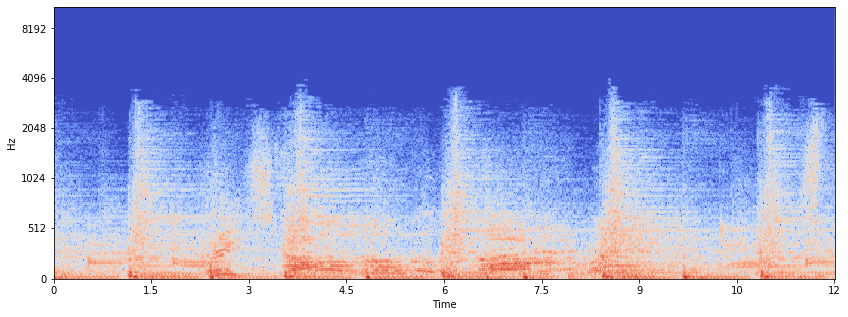

In [33]:
X = librosa.stft(sound_sample, n_fft=512)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=44100, x_axis='time', y_axis='mel')

In [18]:
# Raw sound
ipd.Audio(sound_sample, rate=44100)

In [19]:
irmas_dict[sound_label]

'Human Voice'

In [20]:
feature = create_feature(sound_sample,featured_model+".txt" )

In [21]:
# Sound after augmentation
ipd.Audio(sound_augmenter(sound_sample, augment_parameters), rate=44100)

In [39]:
# Load saved Models
from tensorflow.keras.models import save_model, load_model
#save_model(model,'saved_models/'+ featured_model + '.h5')
model_trained=load_model('saved_models/' + 'AugmentedFFT2.h5', compile=True)
#model_trained=load_model('saved_models/' + 'MELComposed.h5', compile=True) 
model_trained.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

In [23]:
mic_stream = sd.InputStream(device=0, channels=1, samplerate=44100, dtype='float32')
mic_stream.start()

In [24]:
frame_length = 132299 # 3 Seconds
mic_frame = mic_stream.read(frame_length)
mic_frame = mic_frame[0].squeeze()

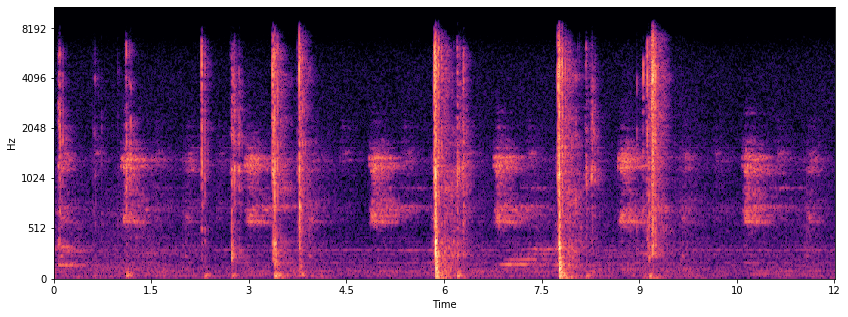

In [25]:
%matplotlib inline
mic_frame = mic_stream.read(frame_length)[0].squeeze()
X = librosa.stft(mic_frame, n_fft=512)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=44100, x_axis='time', y_axis='mel')

In [26]:
ipd.Audio(mic_frame, rate=44100)

In [27]:
#feature = create_feature(mic_frame, param_file='MEL_dB_decompose_all.txt')
feature = create_feature(mic_frame, param_file='FFT_Complex_224x224.txt')
feature = feature[np.newaxis, :]

In [28]:
# Do a prediction
predicted = model_trained.predict(feature)
predicted = predicted.squeeze()

In [29]:
np.array(predicted).shape

(11,)

In [30]:
irmas_dict

{0: 'Cello',
 1: 'Clarinet',
 2: 'Flute',
 3: 'Acoustic Guitar',
 4: 'Electric Guitar',
 5: 'Organ',
 6: 'Piano',
 7: 'Saxophone',
 8: 'Trumpet',
 9: 'Violin',
 10: 'Human Voice'}

In [40]:
# Run a constant prediction
frame_length = 132299
try:
    while True:
        mic_frame = mic_stream.read(frame_length)
        mic_frame = mic_frame[0].squeeze()
        feature = create_feature(mic_frame, param_file='FFT_Complex_224x224.txt')
        #feature = create_feature(mic_frame, param_file='MEL_dB_decompose_all.txt')
        feature = feature[np.newaxis, :]
        predicted = model_trained.predict(feature)
        predicted = predicted.squeeze() 
        #print(np.around(predicted, decimals = 3))
        dominant = predicted.argmax()
        print(np.around(predicted[dominant], decimals = 3), irmas_dict[dominant])
        #print(np.around(predicted[dominant], decimals = 3), irmas_nov_dict[dominant])
        #for i in range(len(predicted)):
            #print(np.around(predicted[i], decimals = 1), irmas_dict[i])
            #print(irmas_dict[])
        #print("--------")

except KeyboardInterrupt:
    print("Press Ctrl-C to terminate while statement")
    pass

0.092 Clarinet
0.092 Saxophone
0.092 Clarinet
0.092 Human Voice
0.092 Human Voice
0.092 Cello
0.091 Trumpet
0.092 Human Voice
0.092 Human Voice
0.093 Clarinet
0.093 Clarinet
0.093 Clarinet
0.092 Clarinet
0.092 Human Voice
0.092 Trumpet
0.091 Human Voice
Press Ctrl-C to terminate while statement
